In [59]:
import numpy as np
import math
import matplotlib.pyplot as plt
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import TensorBoard
from time import time
import itertools
from math import factorial

In [60]:
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

In [61]:
def generateData(data, perm):
    n = data.shape[0]
    blockSize = n // len(perm)
    dataSet = np.zeros(data[0].shape)
    for i in perm:
        block = data[i*blockSize:(i+1)*blockSize]
#         print(block, end='\n\n')
        dataSet = np.vstack((dataSet, block))
    dataSet = dataSet[1:]
    return dataSet

In [62]:
# dataframe = read_csv('sp500.csv')
fields = ['open', 'close']
dataframe = read_csv('GOOGL_data.csv', skipinitialspace = True, squeeze = True, usecols = fields)

print(dataframe.head())
data = np.array(dataframe)
print(data.shape)

       open     close
0  390.4551  393.0777
1  389.5892  391.6012
2  391.2659  390.7403
3  390.4551  391.8214
4  390.2549  394.3039
(1259, 2)


In [63]:
# dataset = dataset.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data[:5])

[[0.00683718 0.01210825]
 [0.0057589  0.01027231]
 [0.00784685 0.00920184]
 [0.00683718 0.01054612]
 [0.00658788 0.01363296]]


In [64]:
split = 0.75
trainSize = int(len(data)*split)
testSize = len(data)-trainSize
print(trainSize)
print(testSize)

944
315


In [65]:
numInterval = 3
blockSize = trainSize//numInterval
print(blockSize)


314


In [66]:
    train = data[0:trainSize,:]
    test = data[trainSize:len(data),:]
    print(train[:5])

[[0.00683718 0.01210825]
 [0.0057589  0.01027231]
 [0.00784685 0.00920184]
 [0.00683718 0.01054612]
 [0.00658788 0.01363296]]


Epoch 1/5
938/938 [==============================] - 6s 6ms/step - loss: 0.0013
Epoch 2/5
938/938 [==============================] - 5s 5ms/step - loss: 3.7123e-04
Epoch 3/5
938/938 [==============================] - 5s 5ms/step - loss: 2.8717e-04
Epoch 4/5
938/938 [==============================] - 5s 5ms/step - loss: 2.4313e-04
Epoch 5/5
938/938 [==============================] - 6s 6ms/step - loss: 2.1923e-04
Train Score: 10.04 RMSE
Test Score: 16.78 RMSE
Epoch 1/5
938/938 [==============================] - 7s 7ms/step - loss: 0.0016
Epoch 2/5
938/938 [==============================] - 6s 6ms/step - loss: 7.1690e-04
Epoch 3/5
938/938 [==============================] - 6s 6ms/step - loss: 6.2263e-04
Epoch 4/5
938/938 [==============================] - 6s 6ms/step - loss: 5.1044e-04
Epoch 5/5
938/938 [==============================] - 5s 6ms/step - loss: 4.3297e-04
Train Score: 14.31 RMSE
Test Score: 11.67 RMSE
Epoch 1/5
938/938 [==============================] - 6s 7ms/step - loss: 0

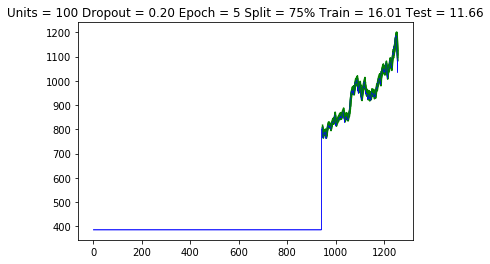

In [67]:
# print(train, end="\n\n")
permutations = itertools.permutations(range(numInterval))
testBand = []
for perm in permutations:
    trainSet = generateData(train, perm)
    trainSet = np.reshape(trainSet, trainSet.shape)
    shuffleData = np.vstack((trainSet, test))

    lookBack = 3
    trainX, trainY = create_dataset(trainSet, lookBack)
    testX, testY = create_dataset(test, lookBack)

    # trainX = np.reshape(trainX, (trainX.shape[0], 2, trainX.shape[1]))
    # testX = np.reshape(testX, (testX.shape[0], 2, testX.shape[1]))

    units = 100
    drop = 0.2
    epoch = 5

    model = Sequential()
    model.add(LSTM(units, input_shape=(lookBack, 2)))
    # model.add(Dropout(drop))
    model.add(Dense(2))
    model.compile(loss='mean_squared_error', optimizer='nadam')
#     model.summary()
#     tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
#     model.fit(trainX, trainY, epochs=epoch, batch_size=1, verbose=1, callbacks=[tensorboard])
    model.fit(trainX, trainY, epochs=epoch, batch_size=1, verbose=1)

    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(trainY)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY)

    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))

    trainPredictPlot = np.empty_like(shuffleData)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[lookBack:len(trainPredict)+lookBack, :] = trainPredict

    testPredictPlot = np.empty_like(shuffleData)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(lookBack*2)+2:len(data)-1, :] = testPredict
    testBand.append(testPredict)
#     testPredictPlot[len(trainPredict)+(lookBack*2)+1:len(data)-1, :] = testPredict

    col = 0
    testPlot = np.empty_like(trainSet)
    testPlot[:, :] = 0
    testPlot = np.vstack((testPlot, test))
#     plt.plot(scaler.inverse_transform(shuffleData)[:,col])
#     plt.plot(trainPredictPlot[:,col], color = 'orange')
    plt.plot(testPredictPlot[:,col], color = 'green')
    plt.plot(scaler.inverse_transform(testPlot)[:,col], color = 'blue', linewidth = 0.3)
    plt.title('Units = %d Dropout = %.2f Epoch = %d Split = %d%% Train = %.2f Test = %.2f' % 
            (units, drop, epoch, split*100, trainScore, testScore))
# plt.show()

In [68]:
print(np.mean(testBand[0], axis = 0))
print(np.std(testBand[0], axis = 0))

[928.24176 924.55365]
[97.058105 96.82507 ]


In [69]:
z_alpha = 1.96
n = factorial(numInterval)

confInterval = []

for X in testBand:
    xBar = np.mean(X, axis = 0)
    s = np.std(X, axis = 0)
    l = xBar - 1.96*s/(n**0,.5)
    r = xBar + 1.96*s/(n**0,.5)
    pair = [l, r]
    confInterval.append(pair)

In [70]:
confInterval

[[array([738.00787354, 544.99935913]), array([1118.47564697, 1304.10794067])],
 [array([745.74107361, 549.24487305]), array([1137.64442444, 1340.76940918])],
 [array([743.85862732, 541.5625    ]), array([1144.67237854, 1338.73413086])],
 [array([748.33851624, 556.6635437 ]), array([1129.6313324 , 1334.00527954])],
 [array([755.11512756, 550.2102356 ]), array([1152.75486755, 1339.7885437 ])],
 [array([748.26318359, 549.07748413]), array([1142.72680664, 1339.31204224])]]

In [71]:
confInterval[0][0][0]

738.0078735351562

[0, 0]
[738.0078735351562, 1118.4756469726562]


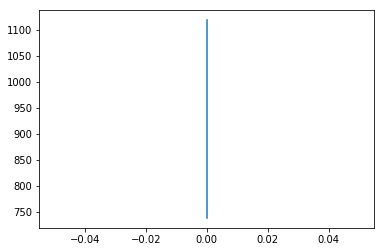

In [72]:
Y = [confInterval[0][0][0], confInterval[0][1][0]]
X = [0, 0]
print(X)
print(Y)
plt.plot(X, Y)
plt.show()

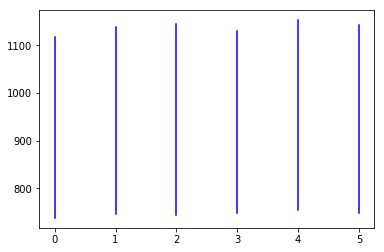

In [78]:
col = 0
for i in range(len(confInterval)):
    X = [i, i]
    Y = [confInterval[i][0][0], confInterval[i][1][0]]
#     print(X)
#     print(Y)
    plt.plot(X, Y, color = "blue")
plt.show()